In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

from PIL import Image

In [2]:
INPUT_PATH = r'C:\Users\AZubochenko\Desktop\DS\DS_02_10_2025\Transfer Learning\data\data'

In [3]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.85, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.85, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])])
}

In [4]:
image_datasets = {
    'train': datasets.ImageFolder(INPUT_PATH + "\\train", data_transforms['train']),
    'validation': datasets.ImageFolder(INPUT_PATH + "\\validation", data_transforms['validation'])
}

In [13]:
data_loaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'], batch_size=32, shuffle=False)
}

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda', index=0)

In [8]:
model = models.resnet101(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False

c:\Users\AZubochenko\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AZubochenko\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [14]:
def train_model(model, criterion, optimizer, num_epochs=3):

  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    print("_"*10)

    for phase in ['train', 'validation']:
      if phase == 'train':
         model.train()
      else:
         model.eval()

      running_loss = 0.0
      running_corrects = 0
      for inputs, labels in data_loaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss/ len(image_datasets[phase])
      epoch_acc = running_corrects.double() / len(image_datasets[phase])

      print ('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

  return model

In [15]:
model_trained = train_model(model, criterion, optimizer, num_epochs=30)

Epoch 1/30
__________
train loss: 0.5159, acc: 0.7752
validation loss: 0.3415, acc: 0.8900
Epoch 2/30
__________
train loss: 0.2557, acc: 0.9020
validation loss: 0.2852, acc: 0.8550
Epoch 3/30
__________
train loss: 0.1870, acc: 0.9308
validation loss: 0.2635, acc: 0.8800
Epoch 4/30
__________
train loss: 0.2272, acc: 0.9063
validation loss: 0.2646, acc: 0.8750
Epoch 5/30
__________
train loss: 0.1665, acc: 0.9452
validation loss: 0.1937, acc: 0.9300
Epoch 6/30
__________
train loss: 0.1470, acc: 0.9366
validation loss: 0.1952, acc: 0.9350
Epoch 7/30
__________
train loss: 0.1841, acc: 0.9280
validation loss: 0.4585, acc: 0.7800
Epoch 8/30
__________
train loss: 0.1534, acc: 0.9294
validation loss: 0.3472, acc: 0.8450
Epoch 9/30
__________
train loss: 0.1124, acc: 0.9611
validation loss: 0.1868, acc: 0.9300
Epoch 10/30
__________
train loss: 0.1329, acc: 0.9452
validation loss: 0.1763, acc: 0.9300
Epoch 11/30
__________
train loss: 0.1444, acc: 0.9366
validation loss: 0.1716, acc: 0.93

In [24]:
validation_img_paths = ["\\validation/alien/55.jpg","\\validation/alien/56.jpg",
                        "\\validation/predator/57.jpg","\\validation/predator/3.jpg"]
img_list = [Image.open(INPUT_PATH+img_path) for img_path in validation_img_paths]
validation_batch = torch.stack([data_transforms['validation'](img).to(device) for img in img_list])

In [25]:
validation_batch.shape

torch.Size([4, 3, 224, 224])

In [26]:
pred_logits = model(validation_batch)

In [27]:
pred_logits

tensor([[ 1.5592, -0.9377],
        [ 5.4590, -5.2119],
        [ 0.7093,  0.3856],
        [-1.0532,  2.6665]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [28]:
pred_probs = F.softmax(pred_logits, dim=1).cpu().data.numpy()

In [29]:
pred_probs

array([[9.2391938e-01, 7.6080628e-02],
       [9.9997675e-01, 2.3208937e-05],
       [5.8023602e-01, 4.1976401e-01],
       [2.3666820e-02, 9.7633320e-01]], dtype=float32)

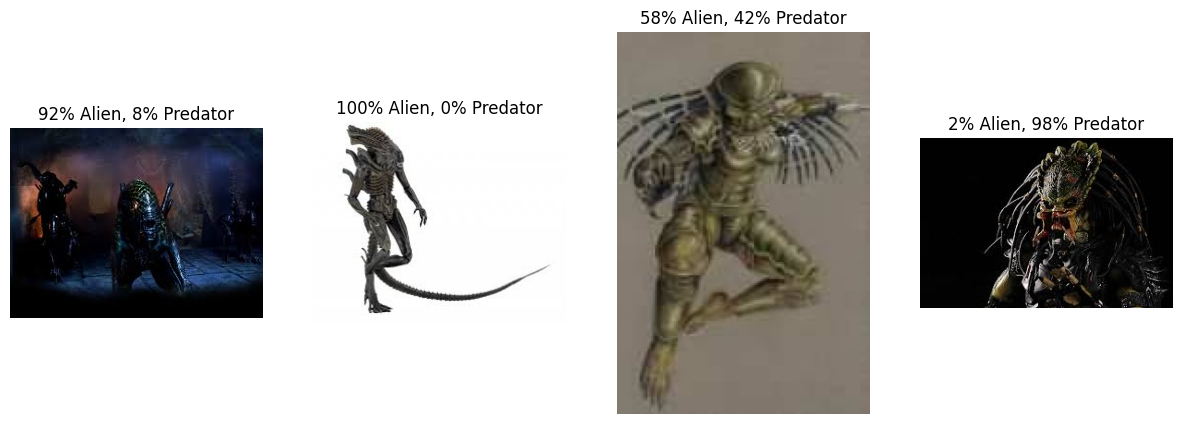

In [30]:
fig, axs = plt.subplots(1, len(img_list), figsize=(15, 10))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)